In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Classifying Photos of Flowers with CNN

In this problem, we have a bunch of photos of five types of flowers, and we want to develop a model that can recognize them. This is a daunting task, since those photos are colored, and are big. To make our life easier, we will use a pre-trained CNN: Inception v3. Let's first load a few functions:

In [42]:
# Common imports
import numpy as np
import scipy
import os
import tensorflow as tf
import sys
import tarfile
from six.moves import urllib

from sklearn.datasets import load_sample_image
from sklearn.datasets import load_sample_images
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")    
    
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
    
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model, Input, Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from mllib.mycallbacks import LRFinder, SGDRScheduler
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim


from random import shuffle

# Transfer Learning

### Classifying large images using Inception v3.

Before starting, since we know that we are going too use a pre-trained model, we need to know how this model was trained. Inception v3 used 299 × 299 pixel photos, with three channels (RGB), and no transparency channel. The images that the Inception model was trained on were preprocessed so that their values range from 0.0 to 1.0, so we must ensure that our images do too.

In [114]:
width = 299
height = 299
channels = 3

For the transfer learning part, let's download the latest pretrained Inception v3 model: the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim. The list of class names is available at https://goo.gl/brXRtZ, but you must insert a "background" class at the beginning.

In [115]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        print("Already downloaded.")
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [116]:
fetch_pretrained_inception_v3()

Already downloaded.


Let's tackle a flower classification problem. First, we need to download it:

In [117]:
FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        print(f'{FLOWERS_PATH} already exists. Please check to see if the dataset is ready')
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [118]:
fetch_flowers()

datasets\flowers already exists. Please check to see if the dataset is ready


Since the image dimensions vary, and that inception_v3 was trained with 299x299x3 images, we have to make sure our images have the same dimensions if we want to reuse this model. We will write simple functions for it.

Each subdirectory of the `flower_photos` directory contains all the pictures of a given class. Let's get the list of classes:

In [127]:
PHOTOS_PATH = os.path.join("datasets", "flowers", "flower_photos")

def get_classes_per_dir(parent_dir):
    return sorted([dirname for dirname in os.listdir(parent_dir)
                  if os.path.isdir(os.path.join(parent_dir, dirname))])

def get_image_label_list(parent_dir, classes):
    if type(classes) is not list:
        print('Not a valid list of labels. Cannot get list.')
        return
    if len(classes) < 2:
        print('Less than two classes. Cannot get list.')
        return

    image_list = {}
    for cls in classes:
        image_list[cls] = list()
        image_dir = os.path.join(parent_dir, cls)
        for filepath in os.listdir(image_dir):
            if filepath.endswith(".jpg"):
                image_list[cls].append(mpimg.imread(os.path.join(image_dir, filepath)))
                
    return image_list

def train_test_images_per_dir(parent_dir, test_ratio=0.2):
    classes = get_classes_per_dir(parent_dir)
    image_list = get_image_label_list(parent_dir, classes)
    X_test = list()
    X_train = list()
    y_test = list()
    y_train = list()
    
    for cls in classes:
        images = image_list[cls].copy()
        shuffle(images)
        ratio = int(test_ratio*len(images))
        X_test.extend(images[:ratio])
        X_train.extend(images[ratio:])
        y_test.extend(ratio * [cls])
        y_train.extend((len(images) - ratio) * [cls])
        
    train = list(zip(X_train, y_train))
    test = list(zip(X_test, y_test))
    
    shuffle(train)
    shuffle(test)

    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)
        
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def resize_images(images, shape=(width,height,channels)):
    return np.array([scipy.misc.imresize(image/255, shape) for image in images])

def labels_to_onehot(y_train, y_test):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(np.unique(y_train))
    y_train = label_binarizer.transform(y_train)
    y_test = label_binarizer.transform(y_test)
    
    return y_train, y_test

def labels_to_int(y_train, y_test):
    label_encoder = LabelEncoder()
    label_encoder.fit(np.unique(y_train))
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    return y_train, y_test

def scale_pixels(imageset):
    return np.asarray([2*(image/255-0.5) for image in imageset], dtype='float32')


In [128]:
X_train, X_test, y_train, y_test = train_test_images_per_dir(parent_dir=PHOTOS_PATH)
X_train = scale_pixels(resize_images(X_train))
X_test = scale_pixels(resize_images(X_test))

C:\Users\barro\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Let's plot one of those images to see what we get:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


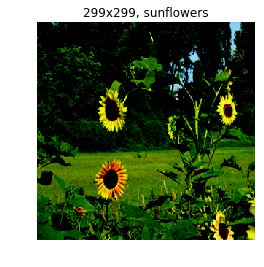

In [136]:
ind = 40
plt.title(f"{X_train[ind].shape[1]}x{X_train[ind].shape[0]}, {y_train[ind]}")
plt.imshow(X_train[ind])
plt.axis("off")
plt.show()

Good, so now let's transform our labels. The network has to deal with numbers, which could be either integers, or one-hot encoding vectors:

In [137]:
#y_train, y_test = labels_to_int(y_train, y_test)
y_train, y_test = labels_to_onehot(y_train, y_test) # just in case we need it, but we need to use 'categorical_crossentropy' as loss

Our dataset is not super big. And because we will train this network over various epochs, ideally we want our model to be trained over a huge variety of photos. Using data augmentation addresses this problem. We will use `ImageDataGenerator()` for it. Now, here we can face some pesky `MemoryError` issues. Here's an elegant solution that I need to have a look into:

https://stackoverflow.com/questions/49458905/memory-error-when-using-keras-imagedatagenerator

https://github.com/tflearn/tflearn/blob/master/examples/basics/use_dask.py

Let's see if we can live without those alternatives:

In [225]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

Let's start by fetching the inception v3 graph again. This time, let's use a `training` placeholder that we will use to tell TensorFlow whether we are training the network or not (this is needed by operations such as dropout and batch normalization).

In [190]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3), pooling="avg")

We will now get the last layer, and from there create a bottleneck model, where we will create a bottle cap using a Dense layer:

In [193]:
base_model.get_layer(index=-1)

In [194]:
bottleneck_input  = base_model.get_layer(index=0).input
bottleneck_output = base_model.get_layer(index=-1).output
bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

Now here we have two options: freeze everything from this model, and not optimize the parameters of it, or to freeze only the deeper layers. Let's see what our model looks like:

In [195]:
print(f"Number of layers:{len(bottleneck_model.layers)}")
bottleneck_model.layers

Number of layers:312


Let's make a test here: we will freeze everything until the last `Conv2D` layer. From there, we will train everything:

In [202]:
bottleneck_model.layers[-23]

In [201]:
# freeze all layers
for layer in bottleneck_model.layers[:-23]:
    layer.trainable = False

In [203]:
bottleneck_model.layers[-23].trainable

True

In [204]:
NUM_CLASSES = len(os.listdir(PHOTOS_PATH))-1  # How many image classes are in our new data?
BOTTLENECK_DIM = base_model.get_layer(index=-3).output.shape.dims[1]    
    
# add your head on top
new_model = Sequential()
new_model.add(bottleneck_model)
new_model.add(Dense(NUM_CLASSES, kernel_initializer='he_normal', activation='softmax'))

In [205]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 2048)              21802784  
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 2,830,341
Non-trainable params: 18,982,688
_________________________________________________________________


In [206]:
# Define the optimizer
optimizer = Adam(lr=0.0033)

# Compile the model
new_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/1
  96/2939 [..............................] - ETA: 2:20 - loss: 1.4732 - acc: 0.3542

C:\Users\barro\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.691939). Check your callbacks.
  % delta_t_median)


2939/2939 [==============================] - 20s 7ms/step - loss: 0.7609 - acc: 0.7996


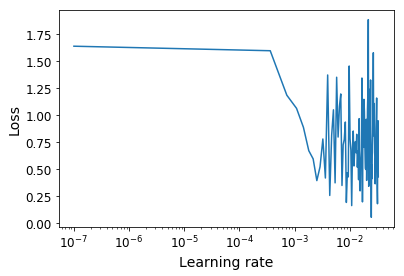

In [207]:
batch_size = 32

lr_finder = LRFinder(min_lr=1e-7, 
                     max_lr=1e-1, 
                     steps_per_epoch=np.ceil(len(X_train) / batch_size), 
                     epochs=3)
es = EarlyStopping(monitor='loss')

new_model.fit(X_train, y_train, callbacks=[lr_finder, es] )
            
lr_finder.plot_loss()

Our `LRFinder` shows us that a learning rate somewhere between 1e-3 and 1e-2 is optimal. But since we will be using Stochastic Gradient Descent with Restarts, I can choose a range going from 0.01 and 0.0001.

In [208]:
batch_size = 64
epochs = 20

schedule = SGDRScheduler(min_lr=1e-4,
                         max_lr=1e-3,
                         steps_per_epoch=np.ceil(len(X_train/batch_size)),
                         lr_decay=0.9,
                         cycle_length=10,
                         mult_factor=1.5)

history = new_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data = (X_test, y_test),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[schedule])

Epoch 1/20
45/45 [==============================] - 58s 1s/step - loss: 0.3838 - acc: 0.8889 - val_loss: 1.6962 - val_acc: 0.7688
Epoch 2/20
45/45 [==============================] - 50s 1s/step - loss: 0.3019 - acc: 0.9130 - val_loss: 1.6174 - val_acc: 0.7702
Epoch 3/20
45/45 [==============================] - 52s 1s/step - loss: 0.2420 - acc: 0.9217 - val_loss: 1.6727 - val_acc: 0.7592
Epoch 4/20
45/45 [==============================] - 52s 1s/step - loss: 0.2138 - acc: 0.9242 - val_loss: 1.5417 - val_acc: 0.7620
Epoch 5/20
45/45 [==============================] - 52s 1s/step - loss: 0.1937 - acc: 0.9360 - val_loss: 1.3941 - val_acc: 0.7729
Epoch 6/20
45/45 [==============================] - 52s 1s/step - loss: 0.1653 - acc: 0.9471 - val_loss: 1.3579 - val_acc: 0.7729
Epoch 7/20
45/45 [==============================] - 52s 1s/step - loss: 0.1677 - acc: 0.9437 - val_loss: 1.2987 - val_acc: 0.7825
Epoch 8/20
45/45 [==============================] - 52s 1s/step - loss: 0.1355 - acc: 0.95

Okay, ~80% out of 5 classes is not bad, but the model overfits. However, this is only after 20 epochs. We could continue training, but this time adding some regularization.

In [221]:
batch_size = 64
epochs = 100

schedule = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-3,
                         steps_per_epoch=np.ceil(len(X_train/batch_size)),
                         lr_decay=0.9,
                         cycle_length=10,
                         mult_factor=1.5)

history = new_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data = (X_test, y_test),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[schedule])

Epoch 1/100
45/45 [==============================] - 56s 1s/step - loss: 0.1085 - acc: 0.9618 - val_loss: 1.1396 - val_acc: 0.8003
Epoch 2/100
45/45 [==============================] - 53s 1s/step - loss: 0.1039 - acc: 0.9638 - val_loss: 1.2647 - val_acc: 0.7852
Epoch 3/100
45/45 [==============================] - 53s 1s/step - loss: 0.0925 - acc: 0.9687 - val_loss: 1.1413 - val_acc: 0.8003
Epoch 4/100
45/45 [==============================] - 54s 1s/step - loss: 0.0808 - acc: 0.9749 - val_loss: 1.0385 - val_acc: 0.8181
Epoch 5/100
45/45 [==============================] - 54s 1s/step - loss: 0.0866 - acc: 0.9705 - val_loss: 1.2313 - val_acc: 0.7893
Epoch 6/100
45/45 [==============================] - 54s 1s/step - loss: 0.0689 - acc: 0.9770 - val_loss: 1.2433 - val_acc: 0.7784
Epoch 7/100
45/45 [==============================] - 54s 1s/step - loss: 0.0675 - acc: 0.9802 - val_loss: 1.1112 - val_acc: 0.7989
Epoch 8/100
45/45 [==============================] - 54s 1s/step - loss: 0.0502 - a

45/45 [==============================] - 54s 1s/step - loss: 0.0073 - acc: 0.9976 - val_loss: 0.8492 - val_acc: 0.8509
Epoch 64/100
45/45 [==============================] - 54s 1s/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.8926 - val_acc: 0.8427
Epoch 65/100
45/45 [==============================] - 54s 1s/step - loss: 0.0058 - acc: 0.9990 - val_loss: 0.8655 - val_acc: 0.8509
Epoch 66/100
45/45 [==============================] - 54s 1s/step - loss: 0.0114 - acc: 0.9982 - val_loss: 0.9203 - val_acc: 0.8386
Epoch 67/100
45/45 [==============================] - 54s 1s/step - loss: 0.0052 - acc: 0.9986 - val_loss: 0.9131 - val_acc: 0.8386
Epoch 68/100
45/45 [==============================] - 54s 1s/step - loss: 0.0070 - acc: 0.9983 - val_loss: 1.0267 - val_acc: 0.8208
Epoch 69/100
45/45 [==============================] - 54s 1s/step - loss: 0.0064 - acc: 0.9983 - val_loss: 0.9507 - val_acc: 0.8331
Epoch 70/100
45/45 [==============================] - 54s 1s/step - loss: 0.0039 - acc: 0

We got an improvement of 6%., but the model training reached saturation. Let's take an aggressive approach to data augmentation:

In [226]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [227]:
batch_size = 64
epochs = 50

history = new_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data = (X_test, y_test),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[schedule])

Epoch 1/50
45/45 [==============================] - 64s 1s/step - loss: 0.0825 - acc: 0.9722 - val_loss: 0.7415 - val_acc: 0.8659
Epoch 2/50
45/45 [==============================] - 53s 1s/step - loss: 0.0770 - acc: 0.9747 - val_loss: 0.7709 - val_acc: 0.8782
Epoch 3/50
45/45 [==============================] - 55s 1s/step - loss: 0.0750 - acc: 0.9746 - val_loss: 0.7134 - val_acc: 0.8851
Epoch 4/50
45/45 [==============================] - 53s 1s/step - loss: 0.0596 - acc: 0.9802 - val_loss: 0.8251 - val_acc: 0.8591
Epoch 5/50
45/45 [==============================] - 53s 1s/step - loss: 0.0586 - acc: 0.9792 - val_loss: 0.7143 - val_acc: 0.8673
Epoch 6/50
45/45 [==============================] - 55s 1s/step - loss: 0.0519 - acc: 0.9816 - val_loss: 0.6667 - val_acc: 0.8974
Epoch 7/50
45/45 [==============================] - 56s 1s/step - loss: 0.0560 - acc: 0.9798 - val_loss: 0.6666 - val_acc: 0.8851
Epoch 8/50
45/45 [==============================] - 54s 1s/step - loss: 0.0463 - acc: 0.98

The model reached a max precision of 91.2% during training. The issue is still that no overall improvement was achieved, and overfitting can be the cause. Let's apply some regularization to the model:

In [230]:
from keras.regularizers import l2

bottleneck_model.layers[-23].kernel_regularizer=l2(1e-4)
bottleneck_model.layers[-22].kernel_regularizer=l2(1e-4)
bottleneck_model.layers[-21].kernel_regularizer=l2(1e-4)
bottleneck_model.layers[-20].kernel_regularizer=l2(1e-4)
bottleneck_model.layers[-18].kernel_regularizer=l2(1e-4)
bottleneck_model.layers[-13].kernel_regularizer=l2(1e-4)

In [232]:
# Define the optimizer
optimizer = Adam(lr=0.0033)

newer_model = Sequential()
newer_model.add(bottleneck_model)
newer_model.add(new_model.layers[-1])
# Compile the model
newer_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [234]:
history = newer_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                  epochs=epochs, validation_data = (X_test, y_test),
                                  verbose=1, steps_per_epoch=X_train.shape[0] // batch_size, 
                                  callbacks=[schedule])

Epoch 1/50
 2/45 [>.............................] - ETA: 2:29 - loss: 0.0194 - acc: 1.0000

C:\Users\barro\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.875229). Check your callbacks.
  % delta_t_median)


45/45 [==============================] - 61s 1s/step - loss: 0.0569 - acc: 0.9816 - val_loss: 0.7602 - val_acc: 0.8687
Epoch 2/50
45/45 [==============================] - 52s 1s/step - loss: 0.0530 - acc: 0.9823 - val_loss: 0.9104 - val_acc: 0.8482
Epoch 3/50
45/45 [==============================] - 54s 1s/step - loss: 0.0430 - acc: 0.9850 - val_loss: 0.8196 - val_acc: 0.8577
Epoch 4/50
45/45 [==============================] - 55s 1s/step - loss: 0.0520 - acc: 0.9826 - val_loss: 0.6153 - val_acc: 0.8865
Epoch 5/50
45/45 [==============================] - 55s 1s/step - loss: 0.0471 - acc: 0.9840 - val_loss: 0.6746 - val_acc: 0.8741
Epoch 6/50
45/45 [==============================] - 55s 1s/step - loss: 0.0367 - acc: 0.9878 - val_loss: 0.6622 - val_acc: 0.8810
Epoch 7/50
45/45 [==============================] - 55s 1s/step - loss: 0.0358 - acc: 0.9857 - val_loss: 0.5874 - val_acc: 0.8960
Epoch 8/50
45/45 [==============================] - 55s 1s/step - loss: 0.0420 - acc: 0.9854 - val_lo

No improvement. Of course we could go on and unfreeze more layers. But I believe that data augmentation would be a better way out. Unfortunately, I couldn't apply more transformation to the data due to MemoryError. This has to be investigated, as there might be alternatives to handle this (using Spark, or even Dask).

As a side note: this [great blog post](https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html) goes into more details and reaches 96% accuracy.